In [6]:
import pandas as pd
import numpy as np
from utils import *
import pytensor.tensor as pt  # Import PyTensor (Theano backend)

In [7]:
df = read_dd_data('../data/PD_data')

# Extract participant information
participants = df["participant"].unique()
n_participants = len(participants)

# Convert participant IDs to integer indices
participant_idx = {pid: i for i, pid in enumerate(participants)}
df["participant_idx"] = df["participant"].map(participant_idx)

'''
Because of the different levels of magnitude
we decide to standarize rewards and reaction times
'''

# used later for unscaling
scaling_factors = {
    "rt_mean": df['rt'].mean(), "rt_std": df['rt'].std(),
    "rcert_mean": df['rcert'].mean(), "rcert_std": df['rcert'].std(),
    "runcert_mean": df['runcert'].mean(), "runcert_std": df['runcert'].std()
}

df["rcert"] = (df["rcert"] - scaling_factors["rcert_mean"]) / scaling_factors["rcert_std"]
df["runcert"] = (df["runcert"] - scaling_factors["runcert_mean"]) / scaling_factors["runcert_std"]
df["rt"] = (df["rt"] - scaling_factors["rt_mean"]) / scaling_factors["rt_std"]

In [8]:
# Load the saved trace
import xarray as xr
trace = xr.open_dataset("probabilistic_discounting_trace.nc")
trace

<xarray.Dataset> Size: 1GB
Dimensions:                      (prob_choose_uncertain_dim_0: 9749,
                                  mu_RT_dim_0: 9749, draw: 2000,
                                  k_raw_dim_0: 49, beta0_dim_0: 49,
                                  lambda_raw_dim_0: 49, beta_dim_0: 49,
                                  beta1_dim_0: 49, sigma_RT_dim_0: 49,
                                  k_dim_0: 49, loss_aversion_dim_0: 49, chain: 4)
Coordinates:
  * prob_choose_uncertain_dim_0  (prob_choose_uncertain_dim_0) int32 39kB 0 ....
  * mu_RT_dim_0                  (mu_RT_dim_0) int32 39kB 0 1 2 ... 9747 9748
  * draw                         (draw) int32 8kB 0 1 2 3 ... 1997 1998 1999
  * k_raw_dim_0                  (k_raw_dim_0) int32 196B 0 1 2 3 ... 46 47 48
  * beta0_dim_0                  (beta0_dim_0) int32 196B 0 1 2 3 ... 46 47 48
  * lambda_raw_dim_0             (lambda_raw_dim_0) int32 196B 0 1 2 ... 47 48
  * beta_dim_0                   (beta_dim_0) int32 196B 0 1 2 3 ... 45 46 47 48
  * beta1_dim_0                  (beta1_dim_0) int32 196B 0 1 2 3 ... 46 47 48
  * sigma_RT_dim_0               (sigma_RT_dim_0) int32 196B 0 1 2 ... 46 47 48
  * k_dim_0                      (k_dim_0) int32 196B 0 1 2 3 4 ... 45 46 47 48
  * loss_aversion_dim_0          (loss_aversion_dim_0) int32 196B 0 1 ... 47 48
  * chain                        (chain) int32 16B 0 1 2 3
Data variables: (12/23)
    prob_choose_uncertain        (chain, draw, prob_choose_uncertain_dim_0) float64 624MB ...
    mu_RT                        (chain, draw, mu_RT_dim_0) float64 624MB ...
    k_raw                        (chain, draw, k_raw_dim_0) float64 3MB ...
    beta0                        (chain, draw, beta0_dim_0) float64 3MB ...
    lambda_raw                   (chain, draw, lambda_raw_dim_0) float64 3MB ...
    beta                         (chain, draw, beta_dim_0) float64 3MB ...
    ...                           ...
    mu_beta1                     (chain, draw) float64 64kB ...
    sigma_beta1                  (chain, draw) float64 64kB ...
    mu_sigma_RT                  (chain, draw) float64 64kB ...
    sigma_sigma_RT               (chain, draw) float64 64kB ...
    sigma_lambda                 (chain, draw) float64 64kB ...
    sigma_k                      (chain, draw) float64 64kB ...
Attributes:
    created_at:                 2025-02-22T11:51:41.850535
    arviz_version:              0.17.1
    inference_library:          pymc
    inference_library_version:  5.20.1
    sampling_time:              1075.914027929306
    tuning_steps:               1000

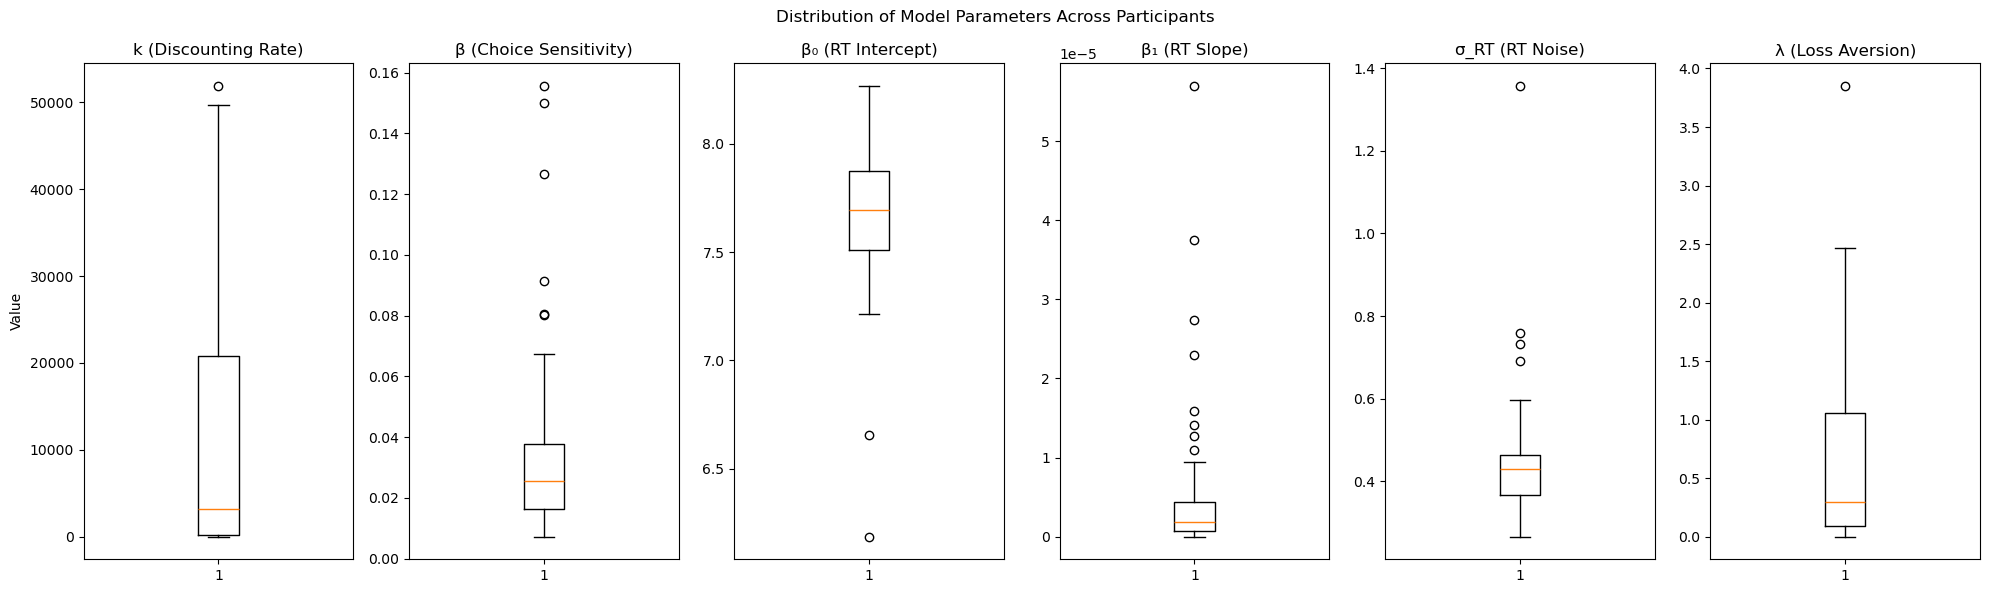

In [9]:
# Extract k values for all participants across chains and draws
k_values = trace.k.median(dim=['chain', 'draw']).values
beta_values = trace.beta.median(dim=['chain', 'draw']).values
beta0_values = trace.beta0.median(dim=['chain', 'draw']).values
beta1_values = trace.beta1.median(dim=['chain', 'draw']).values
sigma_RT_values = trace.sigma_RT.median(dim=['chain', 'draw']).values
loss_aversion_values = trace.loss_aversion.median(dim=['chain', 'draw']).values

# IMPORTANT NOTE: we have an outlier close to 30
# k_values = k_values[k_values < 1]
beta_values = beta_values[beta_values < 1]


import matplotlib.pyplot as plt

# Create a figure with subplots for each parameter
fig, axes = plt.subplots(1, 6, figsize=(20, 6))
fig.suptitle('Distribution of Model Parameters Across Participants')

# Create box plots for each parameter
axes[0].boxplot(k_values)
axes[0].set_title('k (Discounting Rate)')
axes[0].set_ylabel('Value')

axes[1].boxplot(beta_values)
axes[1].set_title('β (Choice Sensitivity)')

axes[2].boxplot(beta0_values)
axes[2].set_title('β₀ (RT Intercept)')

axes[3].boxplot(beta1_values)
axes[3].set_title('β₁ (RT Slope)')

axes[4].boxplot(sigma_RT_values)
axes[4].set_title('σ_RT (RT Noise)')

axes[5].boxplot(loss_aversion_values)
axes[5].set_title('λ (Loss Aversion)')

plt.tight_layout()
plt.show()



